# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.302585
sanity check: 2.302585


In [6]:
np.log(0.1)

-2.3025850929940455

## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [13]:
X_dev

array([[  7.13581020e+01,   2.60182653e+01,  -4.84739184e+01, ...,
         -1.18619592e+01,  -4.63995714e+01,   1.00000000e+00],
       [ -1.01641898e+02,  -9.99817347e+01,  -8.14739184e+01, ...,
          7.91380408e+01,   9.06004286e+01,   1.00000000e+00],
       [ -8.64189796e+00,  -1.89817347e+01,  -7.44739184e+01, ...,
         -2.68619592e+01,  -6.93995714e+01,   1.00000000e+00],
       ..., 
       [ -6.66418980e+01,  -4.39817347e+01,  -8.64739184e+01, ...,
          1.29138041e+02,   1.40600429e+02,   1.00000000e+00],
       [ -4.86418980e+01,  -5.19817347e+01,  -5.94739184e+01, ...,
          1.13804082e+00,  -5.83995714e+01,   1.00000000e+00],
       [ -6.41897959e-01,   1.82653061e-02,  -5.74739184e+01, ...,
         -8.61959184e-01,   5.60042857e+00,   1.00000000e+00]])

In [22]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.000000 analytic: 0.840728, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.561175, relative error: 1.000000e+00
numerical: 0.000000 analytic: 0.177571, relative error: 1.000000e+00
numerical: 0.000000 analytic: 0.937939, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.909288, relative error: 1.000000e+00
numerical: 0.000000 analytic: -1.373268, relative error: 1.000000e+00
numerical: 0.000000 analytic: -2.165975, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.390255, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.655043, relative error: 1.000000e+00
numerical: 0.000000 analytic: -3.038998, relative error: 1.000000e+00
numerical: 0.010789 analytic: -1.216952, relative error: 1.000000e+00
numerical: 0.014663 analytic: -1.521861, relative error: 1.000000e+00
numerical: -0.012375 analytic: -0.562873, relative error: 9.569766e-01
numerical: -0.000266 analytic: 2.393925, relative error: 1.000000e+00
numerical: 0.013583 an

In [27]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.302585e+00 computed in 0.094565s
vectorized loss: 2.330660e+00 computed in 0.004625s
Loss difference: 0.028075
Gradient difference: 135.128682


In [26]:
grad_vectorized

array([[  1.25003828e+00,   5.71594248e-01,   7.03436254e-01, ...,
          1.42310089e+00,   5.12940132e-01,   3.01679068e+00],
       [  2.06478620e+00,  -8.71547321e-01,   1.89593749e+00, ...,
          1.47593993e+00,   1.70185025e+00,   3.82750091e+00],
       [  3.67319045e+00,  -7.80912810e-01,   1.79679865e+00, ...,
          2.02650246e+00,   3.23346192e+00,   5.21080322e+00],
       ..., 
       [  1.15992232e+00,  -8.87035123e-01,   9.90186503e-01, ...,
          1.08324475e+00,  -1.60221005e+00,   7.82722185e-01],
       [  1.64350522e+00,  -2.90147318e-01,   8.52558211e-01, ...,
         -2.50736488e-01,  -1.23929583e-02,   8.42558706e-01],
       [ -1.25770325e-02,  -5.29932418e-03,   3.17345142e-03, ...,
         -7.77096530e-03,  -1.75645138e-02,   2.48839842e-03]])

In [31]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
#pass
cur_acc = 99999999999
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        results[(lr, rs)] = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
        if cur_acc > np.mean(y_val == y_val_pred): 
            best_softmax = softmax
            cur_acc = np.mean(y_val == y_val_pred)


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % cur_acc)

iteration 0 / 1500: loss 783.343566
iteration 100 / 1500: loss 287.673044
iteration 200 / 1500: loss 106.646052
iteration 300 / 1500: loss 40.332527
iteration 400 / 1500: loss 16.113855
iteration 500 / 1500: loss 7.237209
iteration 600 / 1500: loss 3.905803
iteration 700 / 1500: loss 2.780185
iteration 800 / 1500: loss 2.343430
iteration 900 / 1500: loss 2.240669
iteration 1000 / 1500: loss 2.148240
iteration 1100 / 1500: loss 2.076881
iteration 1200 / 1500: loss 2.040378
iteration 1300 / 1500: loss 2.028671
iteration 1400 / 1500: loss 2.083809
iteration 0 / 1500: loss 1532.659379
iteration 100 / 1500: loss 206.290861
iteration 200 / 1500: loss 29.440131
iteration 300 / 1500: loss 5.771990
iteration 400 / 1500: loss 2.626294
iteration 500 / 1500: loss 2.152942
iteration 600 / 1500: loss 2.128563
iteration 700 / 1500: loss 2.111291
iteration 800 / 1500: loss 2.104496
iteration 900 / 1500: loss 2.168129
iteration 1000 / 1500: loss 2.142020
iteration 1100 / 1500: loss 2.122474
iteration 1

In [33]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % cur_acc)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.335163 val accuracy: 0.348000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.304163 val accuracy: 0.331000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.312245 val accuracy: 0.328000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.312776 val accuracy: 0.334000
best validation accuracy achieved during cross-validation: 0.328000


In [34]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.328000


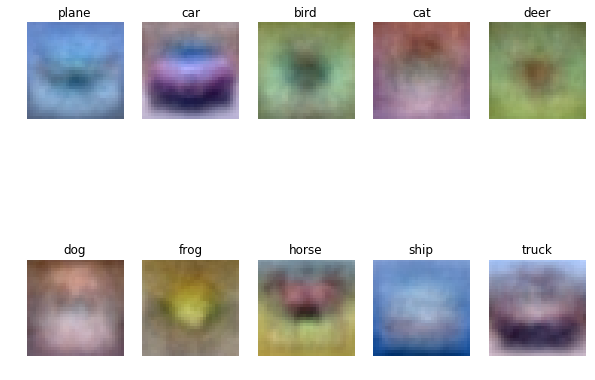

In [35]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])